# Calculate relationship between AP and dendritic spikes as a function of relative phase between excitation and inhibition

The simulations had either: 
1. Sinusoidal inhibition at 64 Hz to the soma, or 16 Hz to the distal dendrites.
2. Sinusoidal excitation to either apical or basal dendrites with different relative phases to the inhibitory rhythm.

Here we calculate the spike-triggered average between dendritic spikes and action potentials. These are stratified by:
1. electrotonic distance of the dendritic segment from the soma
2. whether the dendritic branch was apical or basal
3. type of dendritic spike

The output of this script are a collection of NPY files, one for each simulation condition, dendrite type, and dendritic spike type, containing a numpy array with 3 dimensions:
1. the dendritic segment electrotonic quantile
2. time from the action potential
3. relative phase between excitation and inhibition

In [1]:
import os
import sys
import re
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.cc_serpt import cc_serpt
from src.ser_ss import ser_ss
from src.load_dendevt_csv import load_dendevt_csv
from src.load_spike_h5 import load_spike_h5
from src.permute_pt import permute_pt
from src.seg_dendevt import seg_dendevt
from src.ser_seg_dendevt import ser_seg_dendevt
from src.sta_ap_dendevt import sta_ap_dendevt
from src.bin_serser import bin_serser

# Analysis parameters


In [2]:
samps_per_ms = 10
sim_win = [0, 2000000]
sta_win = [-100, 100]
step = 2 * samps_per_ms

#### List files to be processed

In [3]:
# define method for getting a dataframe of all simulation files
def get_sim_fnames(root_dir):

    # list the names of all the simulations that were run
    sims_list = []
    with os.scandir(root_dir) as flist:
        for f in flist:
            if f.is_dir():
                sims_list.append(f.name)

    # create a data frame of simulation names
    sims_df = pd.DataFrame({'RootDir': root_dir, 'SimName': sims_list})

    # get the relative phase for each simulation and order files by that
    sims_df['RelPhase'] = [int(re.search('([0-9]+)deg',x.SimName).group(1)) for _,x in sims_df.iterrows()]
    sims_df = sims_df.sort_values('RelPhase')

    # get the perent modulation for each simulation 
    sims_df['ModDepth'] = [int(re.search('([0-9]+)p$',x.SimName).group(1)) for _,x in sims_df.iterrows()]

    # and populate with the corresponding action potential and dendritic spike files, ommit name if file does not exist
    sims_df['CaFiles'] = [x if os.path.isfile(x) else pd.NA for x in sims_df['RootDir'] + sims_df['SimName'] + '_ca.csv']
    sims_df['NaFiles'] = [x if os.path.isfile(x) else pd.NA for x in sims_df['RootDir'] + sims_df['SimName'] + '_na.csv']
    sims_df['NMDAFiles'] = [x if os.path.isfile(x) else pd.NA for x in sims_df['RootDir'] + sims_df['SimName'] + '_nmda.csv']
    sims_df['APFiles'] = [x if os.path.isfile(x) else pd.NA for x in sims_df['RootDir'] + sims_df['SimName'] + '\\spikes.h5']

    # print a message indicating any simulations with missing files
    for _, row in sims_df.iterrows():
        if np.any(row.isna()):
            print('For ' + root_dir + ' ' + row['SimName'] + ' is missing files')

    # remove incomplete entries
    sims_df = sims_df.dropna(0)
    return sims_df

# locate simulation files
a_ex_16_df = get_sim_fnames("Y:\\DendCompOsc\\16Hzapical_exc_mod\\")
b_ex_16_df = get_sim_fnames("Y:\\DendCompOsc\\16Hzbasal_exc_mod\\")
a_ex_64_df = get_sim_fnames("Y:\\DendCompOsc\\64Hzapical_exc_mod\\")
b_ex_64_df = get_sim_fnames("Y:\\DendCompOsc\\64Hzbasal_exc_mod\\")

# keep only 30p modulation sims from 64 hz
a_ex_64_df = a_ex_64_df.loc[a_ex_64_df['ModDepth']==30,:]
b_ex_64_df = b_ex_64_df.loc[b_ex_64_df['ModDepth']==30,:]

For Y:\DendCompOsc\16Hzapical_exc_mod\ output_16Hz_dend_inh_30deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzapical_exc_mod\ output_64Hz_soma_inh_0deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzapical_exc_mod\ output_64Hz_soma_inh_30deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzapical_exc_mod\ output_64Hz_soma_inh_60deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzapical_exc_mod\ output_64Hz_soma_inh_90deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzapical_exc_mod\ output_64Hz_soma_inh_120deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzapical_exc_mod\ output_64Hz_soma_inh_150deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzapical_exc_mod\ output_64Hz_soma_inh_180deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzapical_exc_mod\ output_64Hz_soma_inh_210deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzapical_exc_mod\ output_64Hz_soma_inh_240deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzapical_exc_mod\ output_64Hz_soma_inh_270deg_exc_10p is missing 

C:\Users\dbh60\AppData\Local\Temp/ipykernel_13492/445169018.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  sims_df = sims_df.dropna(0)


For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_0deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_60deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_90deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_120deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_150deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_180deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_210deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_240deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_270deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_300deg_exc_10p is missing files
For Y:\DendCompOsc\64Hzbasal_exc_mod\ output_64Hz_soma_inh_330deg_exc_10p is missing files


#### Generate STAs for dendritic spikes

In [4]:
# calculate STAs
def dend_spk_sta(dend_fname, spk_fname):
    
    dend_t = load_dendevt_csv(dend_fname)
    spk_t = load_spike_h5(spk_fname)
    
    dend_seg = seg_dendevt(dend_t)
    dend_seg = ser_seg_dendevt(dend_seg, step_len=step, win_lim=sim_win)
    dend_seg = sta_ap_dendevt(dend_seg, np.round(spk_t / step), bin=1, win=sta_win)

    dend_seg = dend_seg.groupby(('Type')).aggregate({'sta': np.vstack})
    return dend_seg

# process a simulation
def proc_sim(sim_df):
    ca_sta = []
    nmda_sta = []
    na_sta = []
    for _, row in sim_df.iterrows():
        print(row['SimName'])
        ca_sta.append(dend_spk_sta(row['CaFiles'], row['APFiles']))
        nmda_sta.append(dend_spk_sta(row['NMDAFiles'], row['APFiles']))
        na_sta.append(dend_spk_sta(row['NaFiles'], row['APFiles']))
    
    a_ca_sta = np.stack([x.loc['apic','sta'] for x in ca_sta],axis=2)

    a_nmda_sta = np.stack([x.loc['apic','sta'] for x in nmda_sta],axis=2)
    b_nmda_sta = np.stack([x.loc['dend','sta'] for x in nmda_sta],axis=2)

    a_na_sta = np.stack([x.loc['apic','sta'] for x in na_sta],axis=2)
    b_na_sta = np.stack([x.loc['dend','sta'] for x in na_sta],axis=2)

    return {'ca_a': a_ca_sta, 'nmda_a': a_nmda_sta, 'nmda_b': b_nmda_sta,
            'na_a': a_na_sta, 'na_b': b_na_sta}

In [5]:
# process basal excitation, 16 hz inhibition
b_ex_16_sta = proc_sim(b_ex_16_df)

"""
# process apical excitation, 64 hz inhibition
a_ex_64_sta = proc_sim(a_ex_64_df)

# process basal excitation, 64 hz inhibition
b_ex_64_sta = proc_sim(b_ex_64_df)

# process apical excitation, 16 hz inhibition
a_ex_16_sta = proc_sim(a_ex_16_df)
"""

output_16Hz_dend_inh_0deg_exc_10p


C:\Users\dbh60\AppData\Local\Temp/ipykernel_13492/517817117.py:4: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  dend_t = load_dendevt_csv(dend_fname)


output_16Hz_dend_inh_30deg_exc_10p
output_16Hz_dend_inh_60deg_exc_10p
output_16Hz_dend_inh_90deg_exc_10p
output_16Hz_dend_inh_120deg_exc_10p
output_16Hz_dend_inh_150deg_exc_10p
output_16Hz_dend_inh_180deg_exc_10p
output_16Hz_dend_inh_210deg_exc_10p
output_16Hz_dend_inh_240deg_exc_10p
output_16Hz_dend_inh_270deg_exc_10p
output_16Hz_dend_inh_300deg_exc_10p
output_16Hz_dend_inh_330deg_exc_10p


'\n# process apical excitation, 64 hz inhibition\na_ex_64_sta = proc_sim(a_ex_64_df)\n\n# process basal excitation, 64 hz inhibition\nb_ex_64_sta = proc_sim(b_ex_64_df)\n\n# process apical excitation, 16 hz inhibition\na_ex_16_sta = proc_sim(a_ex_16_df)\n'

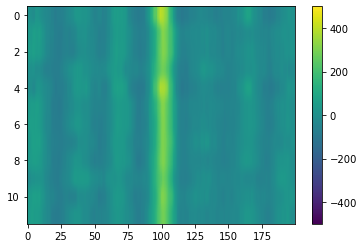

In [119]:
#test = np.squeeze([:,102,:])
data_arr = b_ex_16_sta['ca_a']
data_plt = np.vstack([data_arr[6,:,x] for x in range(12)])
fig, ax = plt.subplots()
ax_im = ax.imshow(data_plt)
ax_im.set_clim([-500,500])
plt.colorbar(ax_im)
ax.set_aspect('auto')
plt.show()

In [72]:
b_ex_16_sta['ca_a'].shape

(9, 200, 12)

In [71]:
test = np.arange(20).reshape((5,4,1))+np.array([[[0,20,40]]])
test2 = np.vstack([test[:,:,x] for x in range(3)])
test2
#test = np.stack((np.ones((5,4)),np.ones((5,4))*2,np.ones((5,4))*3),axis=2)
#print(test[:,:,:])

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23],
       [24, 25, 26, 27],
       [28, 29, 30, 31],
       [32, 33, 34, 35],
       [36, 37, 38, 39],
       [40, 41, 42, 43],
       [44, 45, 46, 47],
       [48, 49, 50, 51],
       [52, 53, 54, 55],
       [56, 57, 58, 59]])

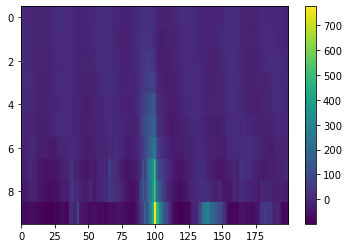

In [14]:
# NMDA spike test
nmda_seg = seg_dendevt(nmda_t)
nmda_seg = ser_seg_dendevt(nmda_seg, step_len=step, win_lim=[0, 2000000])
nmda_seg = sta_ap_dendevt(nmda_seg, np.round(spk_t / step), bin=1, win=sta_win)

# plot results
sta_arr = np.vstack(nmda_seg['sta'])
fig, ax = plt.subplots()
plt.imshow(sta_arr, interpolation='none')
plt.colorbar()
ax.set_aspect('auto')
#plt.clim(-100,400)
plt.show()

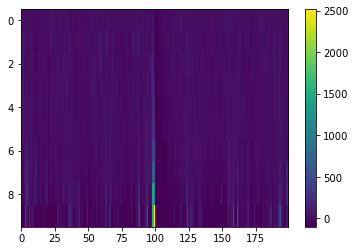

In [18]:
# Na spike test
na_seg = seg_dendevt(na_t)
na_seg = ser_seg_dendevt(na_seg, step_len=step, win_lim=[0, 2000000])
na_seg = sta_ap_dendevt(na_seg, np.round(spk_t / step), bin=1, win=sta_win)

# plot results
sta_arr = np.vstack(na_seg['sta'])
fig, ax = plt.subplots()
plt.imshow(sta_arr, interpolation='none')
plt.colorbar()
ax.set_aspect('auto')
#plt.clim(-100,400)
plt.show()

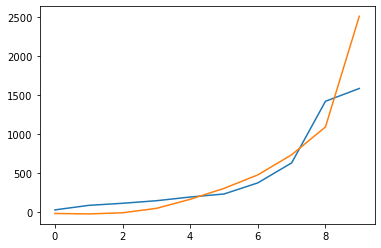

In [23]:
u,s,v = np.linalg.svd(sta_arr)

fig, ax = plt.subplots()
ax.plot(sta_arr[:,98:100])
plt.show()

#fig, ax = plt.subplots()
#ax.plot(np.sum(u[:,0:2]*s[0:2].reshape((1,-1)),1))
#plt.show()